In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from IPython import display
import random
import time
import timeit
# import gym
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
M=128;
dt=1.0/100.0;
T=730;
it=100*730;

w=1.0/15.0;
gamma=.019;
eta=.03;
theta=.56;
A0par=1.0/30.0;

B=np.zeros((M,M));
A0=A0par*np.ones((M,M));
n=np.zeros((M,M));
# print np.int(1.0)

In [ ]:
def neighborMat(A):
    # 4-neighbor sum (edge repeated)
    B = np.zeros(A.shape)
    B[1:,] += A[:-1,]       # up
    B[:-1,] += A[1:,]       # down
    B[:,1:] += A[:,:-1]     # left
    B[:,:-1] += A[:,1:]     # right

#     # correct edges (move out of bound => return to same spot)
#     B[0,] += A[0,]          # up out of bounds
#     B[-1,] += A[-1,]        # down out of bounds
#     B[:,0] += A[:,0]        # left out of bounds
#     B[:,-1] += A[:,-1]      # right out of bounds
    
    # correct edges (periodic)
    B[0,] += A[-1,]         # up out of bounds
    B[-1,] += A[0,]         # down out of bounds
    B[:,0] += A[:,-1]       # left out of bounds
    B[:,-1] += A[:,0]       # right out of bounds

    return B

In [26]:
def update_system(A0,B,n,dt,gamma,eta,theta,w):
    ntemp=np.zeros(n.shape);
    C=np.zeros(n.shape);
    M=n.shape[0]
    A=A0+B;
    
    # precalculate total neighbor attractiveness may still be slightly faster
    tA = neighborMat(A)
    
    # improvement #3: 0.3s to 0.1s per 10 iterations (~n=750)
    nz = np.nonzero(n)
    pDoCrime = np.exp(-A*dt)
    # row,col loop only spots where burlgars are present (n[i,j] > 0)
    for i,j in zip(nz[0],nz[1]):
        # calculate neighbor index once
#         i1 = min(i+1,M-1)   # down
#         i2 = max(i-1,0)     # up
#         j3 = min(j+1,M-1)   # right
#         j4 = max(j-1,0)     # left
        # periodic neighbor instead
        i1 = (i+1)%M
        i2 = (i-1)%M
        j3 = (j+1)%M
        j4 = (j-1)%M
#         totalA = A[i1,j]+A[i2,j]+A[i,j3]+A[i,j4]
        totalA = tA[i,j]
        
        # probabilities for moving to neighbors (same order as above)
        p1 = A[i1,j]/totalA;
        p2 = p1+A[i2,j]/totalA;
        p3 = p2+A[i,j3]/totalA;
#         p4 = p3+A[i,j4]/totalA; # should always be 1
        
        # somehow full loop is faster than calculating this, possibly since k is relatively small
        # crime committed
#         k = np.sum(np.random.rand(np.int(n[i,j]))<(1.0-np.exp(-A[i,j]*dt)))
#         C[i,j] += k
        
#        # remaining move
#         for l in range(np.int(n[i,j]-k)):
        # loop through burglars in position to commit crime or move elsewhere
        for l in range(np.int(n[i,j])):
            # increment crime
#             if((1.0-np.exp(-A[i,j]*dt))>np.random.rand()):
            if(pDoCrime[i,j] < np.random.rand()):
#                 ntemp[i,j]=ntemp[i,j]-1;
                C[i,j] += 1;
            # move to neighboring cell
            else:
#                 temp=A[min(i+1,M-1),j]+A[max(i-1,0),j]+A[i,min(j+1,M-1)]+A[i,max(j-1,0)];
#                     if np.abs(tA[i,j] - temp) > 1e-12:
#                         print("tempA mismatch {} vs {}".format(temp,tA[i,j]))
#                     temp = tA[i,j]
#                 temp = A[i1,j]+A[i2,j]+A[i,j3]+A[i,j4]
                    
#                     u=np.random.rand();
#                     p1=A[min(i+1,M-1),j]/temp;
#                     p2=p1+A[max(i-1,0),j]/temp;
#                     p3=p2+A[i,min(j+1,M-1)]/temp;
#                     p4=p3+A[i,max(j-1,0)]/temp;
#                     if(u<p1):
#                         it=min(i+1,M-1);
#                         jt=j;
#                     if((u<p2) and (u>=p1)):
#                         it=max(i-1,0);
#                         jt=j;
#                     if((u<p3) and (u>=p2)):
#                         it=i;
#                         jt=min(j+1,M-1);
#                     if((u<p4) and (u>=p3)):
#                         it=i;
#                         jt=max(j-1,0);
                
                # np.random.choice(4,k,p=[p1,p2,p3,p4]) outside loop is not faster than this
                # this might change if k very large
                u=np.random.rand();
                if(u < p1):
                    ntemp[i1,j] += 1
                elif(u < p2):
                    ntemp[i2,j] += 1
                elif(u < p3):
                    ntemp[i,j3] += 1
                else:
                    ntemp[i,j4] += 1
                        
    # new criminal count is old one plus those that moved to minus
    # those that moved from or commited crimes
            
#     n=n+ntemp;
    n = ntemp; # no need to subtract n from n then add
    
    # also add criminals to system
    # improvement #1: 0.8s to 0.3s per 10 iterations
#     R = np.random.rand(M**2)
    # 1-D version of n: updates n
    flat_n = n.ravel()
#     flat_n[(1-np.exp(-gamma*dt))>R] += 1
    flat_n[np.random.rand(M**2) > np.exp(-gamma*dt)] += 1
    
#     for i in range(M):
#         for j in range(M):
#             if((1-np.exp(-gamma*dt))>np.random.rand()):
# #             if((1-np.exp(-gamma*dt))>R[j+i*M]):
#                 n[i,j]=n[i,j]+1;

# #     print(np.array_equal(m,n))
                
                

    #update attractiveness based upon recent crimes
    # improvement #1: 1.5s to 0.8s per 10 iterations
#     dB2 = (1-eta)*B + (eta/4)*neighborMat(B)
#     B = theta*C + (1.0-w*dt)*dB2
    B = theta*C + (1.0-w*dt)*((1-eta)*B + (eta/4)*neighborMat(B))
    
#     Btemp=np.copy(B)
#     for i in range(M):
#         for j in range(M):
#             dB=B[i,j]*(1-eta)+(eta/4)*(B[min(i+1,M-1),j]+B[max(i-1,0),j]+B[i,min(j+1,M-1)]+B[i,max(j-1,0)]);
# #             if np.abs(dB2[i,j] - dB) > 1e-16:
# #                 print("dB mismatch {} vs {}".format(dB,dB2[i,j]))
#             Btemp[i,j]=theta*C[i,j]+(1.0-w*dt)*dB;
    
# #     diffB = np.linalg.norm(Btemp2-Btemp,'fro')
# #     if (diffB > 1e-16):
# #         print(diffB)
#     B=np.copy(Btemp)

    return C,B,n

In [ ]:
# consider using this if our n becomes large
def update_system2(A0,B,n,dt,gamma,eta,theta,w):
    ntemp=np.zeros(n.shape);
    C=np.zeros(n.shape);
    M=n.shape[0]
    A=A0+B;
    
    # precalculate total neighbor attractiveness may still be slightly faster
    tA = neighborMat(A)
    
    # TODO: bypass this loop too
    nz = np.nonzero(n)
    pDoCrime = np.exp(-A*dt)
    # row,col loop only spots where burlgars are present (n[i,j] > 0)
    for i,j in zip(nz[0],nz[1]):
        # calculate neighbor index once
        # periodic neighbor instead
        i1 = (i+1)%M
        i2 = (i-1)%M
        j3 = (j+1)%M
        j4 = (j-1)%M
        totalA = tA[i,j]
        
        # this is faster for large n (currently only 1-3)
        k = np.sum(np.random.rand(np.int(n[i,j]))>pDoCrime[i,j])
        C[i,j] += k
        
        # movement for those that do not commit crime
        if k < n[i,j]:
            mvP = [A[i1,j]/totalA,A[i2,j]/totalA,A[i,j3]/totalA,A[i,j4]/totalA]
            mv = np.random.multinomial(int(n[i,j]-k),mvP)
            ntemp[i1,j] += mv[0]
            ntemp[i2,j] += mv[1]
            ntemp[i1,j3] += mv[2]
            ntemp[i1,j4] += mv[3]
                        
    # new criminal count is old one plus those that moved to minus
    # those that moved from or commited crimes
            
    n = ntemp; # no need to subtract n from n then add
    
    # also add criminals to system
    # improvement #1: 0.8s to 0.3s per 10 iterations
    R = np.random.rand(M**2)
    # 1-D version of n: updates n
    flat_n = n.ravel()
    flat_n[(1-np.exp(-gamma*dt))>R] += 1                
                

    #update attractiveness based upon recent crimes
    # improvement #1: 1.5s to 0.8s per 10 iterations
#     dB2 = (1-eta)*B + (eta/4)*neighborMat(B)
#     B = theta*C + (1.0-w*dt)*dB2
    B = theta*C + (1.0-w*dt)*((1-eta)*B + (eta/4)*neighborMat(B))

    return C,B,n

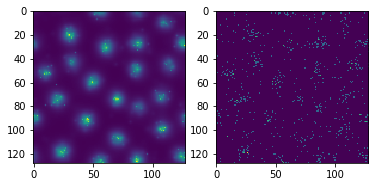

0.7758557796478271
k=14200, n=695.0


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

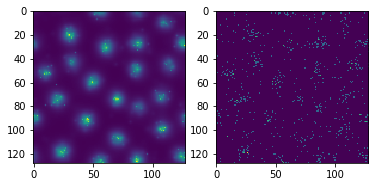

In [29]:
np.random.seed(0)
start = time.time()
for k in range(it):
    C,B,n=update_system(A0,B,n,dt,gamma,eta,theta,w)
    if k % 100 == 0:
        end = time.time()
        plt.clf()
        fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
        ax1.imshow(B)
        ax2.imshow(n)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        print(end-start)
        print("k={}, n={}".format(k,n.sum()))
        start = time.time()

In [ ]:
# testing indexing (abandoned)
np.random.seed(0)
M = 10

# n = [4,2,1,3]
# ix = [[x]*n[x] for x in range(len(n))]
# flat_ix = [y for x in ix for y in x]

# print(ix)
# print(flat_ix)


m = np.zeros((M,M))
p = m.ravel()
for i in range(M**2):
    p[i] = i%100
# p = [x for x in range(16)]
# print(m)
print(p)
plt.imshow(m)

A = np.random.rand(M,M)
B = A.ravel()


# method 1: bad loop
start = time.time()
n = np.int(sum(sum(m)))
z = np.zeros((n,))
count = 0
for i in range(M):
    for j in range(M):
        for k in range(np.int(m[i,j])):
            z[count] = A[i,j]
            count += 1
print(time.time()-start)
print(z.T)

# method 2: better loop?
start = time.time()
n = np.int(sum(sum(m)))
z2 = np.zeros((n,))
count = 0
for i in range(M):
    for j in range(M):
        k = np.int(m[i,j])
        z2[count:count+k] = A[i,j]
        count += k
print(time.time()-start)
print(z2.T)

# list comprehension
start = time.time()
p = m.ravel()
ix = [[x]*np.int(p[x]) for x in range(len(p))]
flat_ix = [y for x in ix for y in x]
y = B[flat_ix]
print(time.time()-start)
print(y)

print(np.shape(z))
print(np.shape(y))
print(np.array_equal(z,y))
print(np.array_equal(z,z2))

In [24]:
# sampling from k-class p
import numpy as np
from scipy.stats import binned_statistic
import time

n = 10000
np.random.seed(0)
data = np.random.rand(n)
p =[0.4, 0.1, 0.2, 0.3]

# method 0 multinomial (fastest)
np.random.seed(0)
t = time.time()
b0 = np.random.multinomial(n,p,1)
print(time.time()-t)
print(b0)

# method 1 digitize (2nd fastest)
t = time.time()
cs = np.cumsum(p)
b1 = np.bincount( np.digitize(data,cs,right=True) )
print (time.time()-t)
print(b1)

# method 2 binned_statistic
t = time.time()
cs = np.append(0,np.cumsum(p))
b2 = binned_statistic(data,data,statistic='count',bins=cs)[0]
print (time.time()-t)
print(b2)

# method 3 loop (fastest for small n <20)
t = time.time()
cs = np.cumsum(p)
b3 = np.zeros(len(p))
for i in range(n):
    if data[i] < cs[0]:
        b3[0] += 1
    elif data[i] < cs[1]:
        b3[1] += 1
    elif data[i] < cs[2]:
        b3[2] += 1
    else:
        b3[3] += 1
print (time.time()-t)
print(b3)

0.027055025100708008
0.00054931640625
[2 0 1 ... 1 0 0]
[2. 2. 3. ... 2. 2. 2.]
